# Normalization EcoDAM and ATAC Data
#### Hagai Har-Gil

## Code Imports

In [3]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
import pathlib
import copy
from typing import Tuple, List

import seaborn as sns
import numpy as np
import pandas as pd
import skimage.exposure
import matplotlib.pyplot as plt
import scipy.signal
import scipy.fftpack

from ecodam_py.bedgraph import BedGraph
from ecodam_py.eco_atac_normalization import (
    put_on_even_grounds,
    preprocess_bedgraph,
    preprocess_theo,
    convert_to_intervalindex,
    generate_intervals_1kb,
    reindex_data_with_known_intervals,
    reindex_theo_data,
    generate_df_for_theo_correlation_comparison,
    show_ridge_plot,
    subtract_background_with_theo,
    equalize_distribs,
    plot_bg,
    find_closest_diff,
    expand_seeds,
    concat_clusters,
    normalize_df_between_01,
    write_intindex_to_disk,
    get_index_value_for_peaks,
)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

## Code Runthrough

### Preparations

Here we define the filenames used (Eco, ATAC, naked Eco and theoretical Eco) and do a bit of preprocessing to turn them into usable objects. The ATAC data's loci are defined a bit weirdly, so we also normalize it to a proper format. 

In [6]:
eco_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/chromatin_chr15.filter17_60_75.NoBlacklist.NoMask.bedgraph"
)
atac_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/ATAC_rep1to3_Fold_change_over_control.chr15.bedgraph"
)
naked_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/NakedAF647_channel2_chr15_NoMissingChromatinWin.BEDgraph"
)
theo_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data/hg38.1kb.windows.InSilico.count.map.sum.bedgraph"
)

<IPython.core.display.Javascript object>

In [9]:
beds = preprocess_bedgraph([eco_fname, atac_fname, naked_fname])
beds[1].data.loc[:, "end_locus"] += 100  # ATAC data is built a bit differently

<IPython.core.display.Javascript object>

### Theoretical data pre-processing

In parallel we prepare the theoretical data - turn it into an object and reindex it so that it refers to the exact same loci as the naked data, which serves as its reference point. 

There's some averaging going on here, since currently the theoretical data is sampled at (1000, 2000, 3000, ...) bp while the rest of the data is sampled at (500, 1500, 2500, ...) bp. This means that if we want the theoretical data to point at the exact same loci as the naked one, we have to average out every two theoretical values (at least) to find their middle point, which will serve as the new index for the data. This bit will run in `reindex_theo_data`, which is called after the next cell.

In [12]:
theo = preprocess_theo(theo_fname)

<IPython.core.display.Javascript object>

### Coercion to the same loci

Next up, we need to do a bit of manipulation to make sure that all values for the different measurements are defined for the exact same loci. The theoretical data will get special treatment later.

The function `put_on_even_grounds` makes sure that the datasets start and end in the same locus, and the `generate_intervals_1kb` function is called on the ATAC data to smooth it out and finally "reindex" it so that it refers to the same loci as the rest of the data. The index here is the locus values at which the measurement was made. Finally, the function `reindex_data_with_known_intervals` does the work of actually changing the indices of the datasets which aren't Eco with chromatin.

In [ ]:
beds = put_on_even_grounds(beds)
beds = convert_to_intervalindex(beds)
newint = generate_intervals_1kb(beds[1].data)
eco = beds[0]
atac = beds[1]
naked = beds[2]
atac.data, naked.data, theo.data = reindex_data_with_known_intervals(
    newint, atac, naked, theo, eco.data.index
)
theo.data = reindex_theo_data(naked.data, theo.data)

In [7]:
eco.data

,chr,intensity
locus,,
"[22632500, 22633500)",chr15,215.66414
"[22633500, 22634500)",chr15,220.00566
"[22634500, 22635500)",chr15,256.38684
"[22635500, 22636500)",chr15,241.01006
"[22636500, 22637500)",chr15,277.31815
...,...,...
"[101711500, 101712500)",chr15,159.94940
"[101712500, 101713500)",chr15,157.86397
"[101713500, 101714500)",chr15,181.95297


<IPython.core.display.Javascript object>

### Naked data validation

To validate our naked data we'll use the theoretical data we've just pre-processed and see if they're correlated. There are many ways to check the correlation of these types of data, but in this case we'll try to look at the distributions of the naked data that correspond to different quantiles of the theoretical data. In simple terms, where there's a large concentration of DAM sites we expect to receive higher readings in the naked data, and vice versa for the lower concentration data. To show this correlation we'll generate a "ridge plot" for quantiles of the theoretical data.

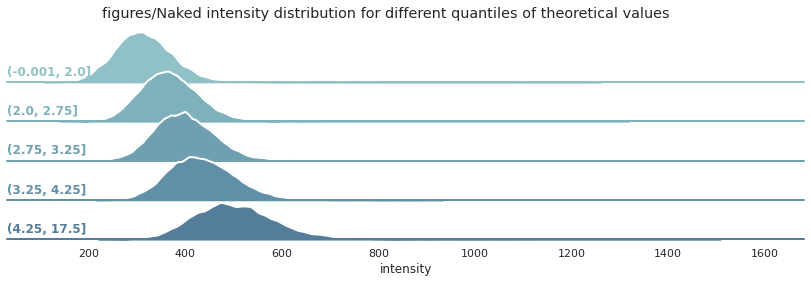

<IPython.core.display.Javascript object>

In [8]:
long_form_naked_data = generate_df_for_theo_correlation_comparison(
    naked.data.copy(), theo.data
)
fg = show_ridge_plot(long_form_naked_data, name="naked")

This pretty-looking plot shows a few interesting things about the naked data:

1. The SNR is quite low. Having very low concentration of sites still results in an intensity value of a few hundreds, and adding a lot more sites (5+) only increases this 'affinity' two-fold.
2. The high degree of overlap between the distributions may point us towards issues with the data acquisition. The data might be changing too rapidly for the microscope to detect, generating some sort of a bleed-through between the different  quantiles.
3. Nonetheless, the correlation between the site density and the intensity is definitely there, which is great.
4. The data is stretching towards the right due to a few high values in the higher quantiles. They're probably meaningless.

We can also think of doing the same analysis to the chromatin data, and look for possible differences.

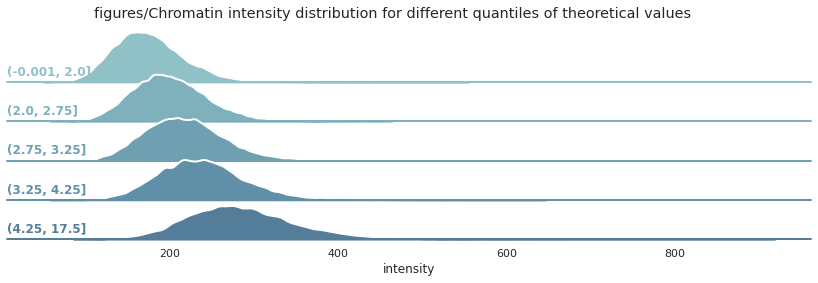

<IPython.core.display.Javascript object>

In [9]:
long_form_eco_data = generate_df_for_theo_correlation_comparison(
    eco.data.copy(), theo.data
)
fg = show_ridge_plot(long_form_eco_data, name="chromatin")

This plot is very similar to the naked one, but with lower absolute intensity values and a smaller difference between the peaks. It seems that indeed some of the DNA is hidden behind chromatin.

### Naked data normalization

The naked data is now ready to be normalized using the "improved" theoretical data. This normalization step occurs in `subtract_background_with_theo` and in `normalize_by_site_density` and consists of two steps:
1. **Subtract the background noise.** We identify noise as loci where the theoretical data insists that no Eco sites exist, but the naked data is still showing some readings. This necessarily means that we hit the noise floor, and we can subtract that value without concern. As seen in the histogram below, the noise is noisy, which means that the noise floor isn't contained to a single intensity value. A conservative approach that is applied here is to use the mean value of that Gaussian as the background noise, and clip the data at that value - i.e. all values at or below this value are zeroed.
2. **Normalize by site density.** We should also take into account the distribution of site density when observing the naked data. A simple approach is to divide the naked intensity by the theoretical value. Higher densities will lower the the intensity values, while lower ones will increase it. The function `normalize_by_site_density` does exactly that, but we'll only use it on the accessability map, which is the dataset that is created after finding the correlation between the naked data and the chromatin one. This is because the ridge plots we saw above, the ones which show the Eco\Naked distribution as a function of the theoretical data, show that it this normalization is not as important as you might think.

At this point we're only subtracting the BG from the naked data. We'll run the normalization step later, if deemed necessary.

In [10]:
naked.data = subtract_background_with_theo(naked.data, theo.data)

<IPython.core.display.Javascript object>

#### Eco Data normalization

Since this normalization step seems to work well, we'll try normalize the Eco data as well in the same way, before we process it further.

In [11]:
eco.data = subtract_background_with_theo(eco.data, theo.data)

<IPython.core.display.Javascript object>

### Chromatin and naked normalization

The next step is to compare the chromatin and naked data to the ATAC in order for us to find areas with similarities. We do that by first equalizing the distributions of the naked and chromatin data to those of the ATAC using the `equalize_distribs` function. This means that we spread them, in a linear fashion, over the same set of values.

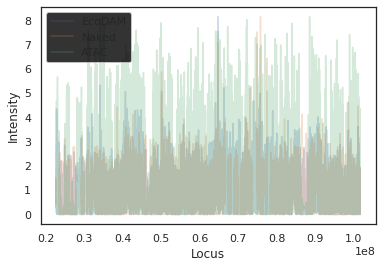

<IPython.core.display.Javascript object>

In [12]:
eco_and_naked = equalize_distribs([eco.data.drop("chr", axis=1), naked.data], atac.data)
eco_no_min, naked_no_min = eco_and_naked[0], eco_and_naked[1]
ax = plot_bg(eco_no_min, naked_no_min, atac.data)

### Using ATAC peaks as normalizations for Naked and Eco

We have the loci where the ATAC is considered open due to our work with HMMRATAC and MACS2, as seen in the `peak_calling` module and notebook. We can take these peaks are ground truth for the next step. Our goal will be to generate a track, similar to the ATAC track, that should be high in open loci and low in closed loci. To achieve it we'll use the high areas in the ATAC as indices where the naked and chromatin data should be approximately equal. We'll equalize their distributions based on these areas and then perform a subtraction to get that track.

In [13]:
peak_calling_atac = pd.read_csv(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/hmm_output/NA_summits.bed",
    sep="\t",
    names=["chr", "start", "end", "peaknum", "height"],
)

<IPython.core.display.Javascript object>

This notebook currently only deals with chromosome 15, so first we filter the relevant peaks and then connect them to our existing 1 kb sampled index:

In [14]:
peaks_chr15 = peak_calling_atac.query('chr == "chr15" & height > 50')
peaks_chr15 = get_index_value_for_peaks(peaks_chr15, eco.data)
non_peaks_chr15 = np.setdiff1d(np.arange(len(eco.data)), peaks_chr15)

<IPython.core.display.Javascript object>

Let's observe the correlation of the naked and chromatin data in these locations using a scatterplot:

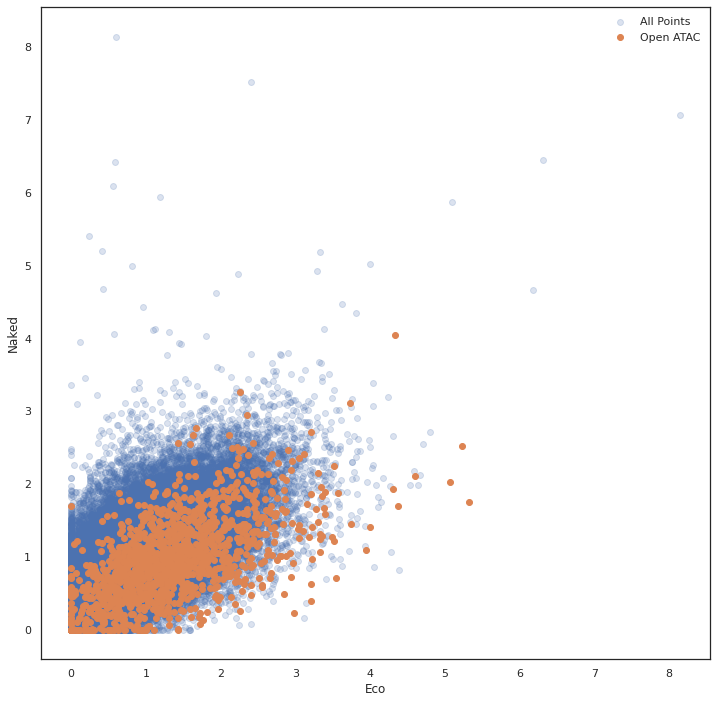

<IPython.core.display.Javascript object>

In [15]:
top_eco = eco_no_min.iloc[peaks_chr15]
non_top_eco = eco_no_min.intensity.iloc[non_peaks_chr15]
top_naked = naked_no_min.iloc[peaks_chr15]
non_top_naked = naked_no_min.iloc[non_peaks_chr15].intensity
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlabel("Eco")
ax.set_ylabel("Naked")
ax.scatter(
    non_top_eco,
    non_top_naked,
    alpha=0.2,
    label="All Points",
)
ax.scatter(top_eco.intensity, top_naked.intensity, label="Open ATAC")
ax.legend(
    loc="upper right",
    frameon=False,
    shadow=False,
)

Text(0, 0.5, 'Open ATAC')

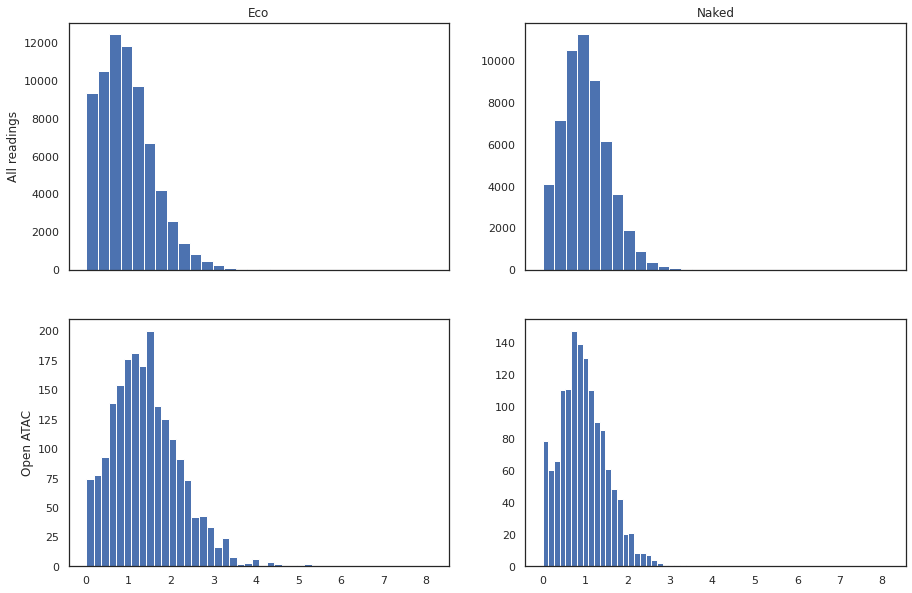

<IPython.core.display.Javascript object>

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
ax[0, 0].hist(non_top_eco, bins=30)
ax[1, 0].hist(top_eco.intensity, bins=30)
ax[0, 1].hist(non_top_naked, bins=30)
ax[1, 1].hist(top_naked.intensity, bins=30)
ax[0, 0].set_title("Eco")
ax[0, 1].set_title("Naked")
ax[0, 0].set_ylabel("All readings")
ax[1, 0].set_ylabel("Open ATAC")

The differences are very small - the peak-based Eco data is just slightly higher than the rest of the data. This is, again, a testament to the low SNR we're working with.

We can also look at the reverse direction - how do the ATAC values loook like at the peaks of the Eco?

Text(0, 0.5, 'Top Eco Points')

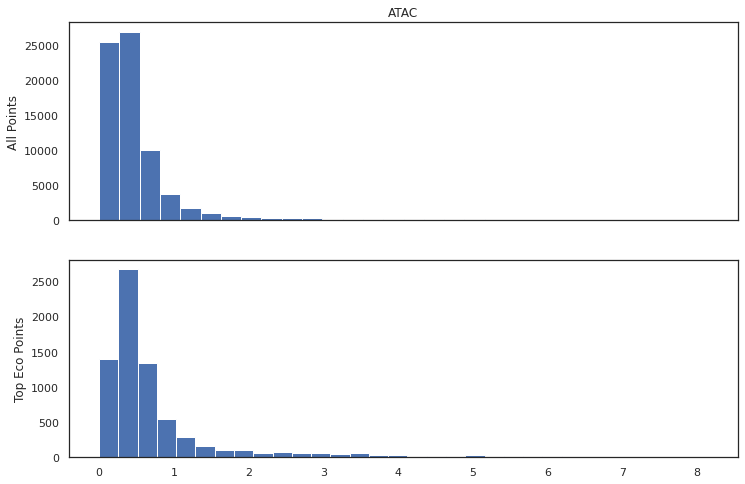

<IPython.core.display.Javascript object>

In [17]:
quant = eco_no_min.intensity.quantile(0.9)
top_eco_quant = eco_no_min.query("intensity > @quant")
top_atac_quant = atac.data.loc[top_eco_quant.index]
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].hist(atac.data.intensity, bins=30)
ax[1].hist(top_atac_quant.intensity, bins=30)
ax[0].set_title("ATAC")
ax[0].set_ylabel("All Points")
ax[1].set_ylabel("Top Eco Points")

Again there seems to be no difference.

### Normalization of Naked and Chromatin by ATAC peaks - 2nd try

We'll try a new method for normalization. Consider that the open parts of the genome should have bright fluorescence, and that brightness value should be approximately equal for all open parts of the genome. Here's we'll try to find a normalization factor that turns all of the peaks of the Naked and Chromatin tracks to an equal hight, and then we could subtract the two tracks.

This will result in a third track that should be a mirror image of the original ATAC track, since the open areas will be very low (high Naked - high chromatin) while the closed areas should be quite bright (high naked - low chromatin).

In [48]:
# Divide the peaks into groups
groupsize = 100
segments = np.arange(groupsize, len(peaks_chr15), groupsize, dtype=np.int64)
# Define the limits of each group using peak index
peak_segments = peaks_chr15[segments]
peak_groups = np.split(peaks_chr15, segments)
# Split up data at these intervals
naked_groups = np.split(naked_no_min, peak_segments)
eco_groups = np.split(eco_no_min, peak_segments)

<IPython.core.display.Javascript object>

In [49]:
# Change peak indices to relative per group
peak_segments = np.concatenate([[0], peak_segments])
peak_groups_relative = [
    group - starting for group, starting in zip(peak_groups, peak_segments)
]

<IPython.core.display.Javascript object>

In [61]:
def normalize_group_peaks_single_factor(peaks: np.ndarray, data: pd.DataFrame, norm_to: float = None):
    peak_median = data.intensity.iloc[peaks].median()
    if not norm_to:
        return data, peak_median
    normed = data.loc[:, ["intensity"]] * (norm_to / peak_median)
    return normed, -1

<IPython.core.display.Javascript object>

In [62]:
subtraction = pd.DataFrame(columns=['intensity'], index=eco_no_min.index)
for peaks, nakedgroup, ecogroup in zip(peak_groups_relative, naked_groups, eco_groups):
    eco_norm, norm = normalize_group_peaks(peaks, ecogroup)
    naked_norm, _ = normalize_group_peaks(peaks, nakedgroup, norm_to=norm)
    subtraction.loc[eco_norm.index] = naked_norm - eco_norm


<IPython.core.display.Javascript object>

In [64]:
write_intindex_to_disk(
    subtraction.dropna(),
    naked_fname.parent.with_name("naked_after_eco_subtraction.bedgraph"),
)

/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

<IPython.core.display.Javascript object>

### Seeding and expansion

The question that remains unanswered is how to compare the ATAC and chromatin tracks. We eventually wish to find close and open areas in the genome, and for that we should use every piece of data we possess. As a start, we'll use _seeding_ to identify similar looking regions. 

Seeds are areas that show a large similarity in the track's shape between the Eco and ATAC data. To find them, we subtract the now-equalized traces and look for the smallest differences. These points are the seeds, and we expand them by some amount to identify whether this similarity was accidental or whether it truly reflects the underlying data.

Interestingly, when looking at seeds from the Eco data they should usually point to areas with an open DNA, but the naked seeds should be scattered around all over the place, since all of the genome was open. Thus we might look for the distribution of events over the loci instead of at the values themselves.

In [19]:
closest_eco, closest_atac_eco = find_closest_diff(
    eco_no_min.loc[:, "intensity"].copy(), atac.data.loc[:, "intensity"].copy()
)
closest_naked, closest_atac_naked = find_closest_diff(
    naked.data.intensity.copy(), atac.data.intensity.copy()
)
clusters_eco = expand_seeds(closest_eco.copy())
clusters_naked = expand_seeds(closest_naked.copy())
clustered_eco, clustered_atac_eco = concat_clusters(
    eco_no_min.copy(), atac.data.copy(), clusters_eco.copy()
)
clustered_naked, clustered_atac_naked = concat_clusters(
    naked.data.copy(), atac.data.copy(), clusters_naked.copy()
)
write_intindex_to_disk(
    closest_atac_eco,
    atac_fname.parent.with_name(
        "ATAC_rep1to3_Fold_change_over_control.chr15_seeds_top_similarities_with_eco.bedgraph"
    ),
)
write_intindex_to_disk(
    closest_atac_naked,
    atac_fname.parent.with_name(
        "ATAC_rep1to3_Fold_change_over_control.chr15_seeds_top_similarities_with_naked.bedgraph"
    ),
)
write_intindex_to_disk(
    closest_eco,
    eco_fname.parent.with_name(
        "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_seeds_top_similarities_with_atac.bedgraph"
    ),
)
write_intindex_to_disk(
    clustered_eco,
    eco_fname.parent.with_name(
        "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_seeds_top_similarities_with_atac_after_expansion.bedgraph"
    ),
)
write_intindex_to_disk(
    clustered_atac_eco,
    atac_fname.parent.with_name(
        "ATAC_rep1to3_Fold_change_over_control.chr15_seeds_top_similarities_with_eco_after_expansion.bedgraph"
    ),
)
write_intindex_to_disk(
    clustered_atac_naked,
    atac_fname.parent.with_name(
        "ATAC_rep1to3_Fold_change_over_control.chr15_seeds_top_similarities_with_naked_after_expansion.bedgraph"
    ),
)
write_intindex_to_disk(
    closest_naked,
    naked_fname.parent.with_name(
        "NakedAF647_channel2_chr15_NoMissingChromatinWin_no_background_seeds_top_similarities_with_atac.bedgraph"
    ),
)
write_intindex_to_disk(
    clustered_naked,
    naked_fname.parent.with_name(
        "NakedAF647_channel2_chr15_NoMissingChromatinWin_no_background_seeds_top_similarities_with_atac_after_expansion.bedgraph"
    ),
)

<IPython.core.display.Javascript object>

In [20]:
normed_naked = normalize_df_between_01(naked.data.copy())
normed_eco = normalize_df_between_01(eco_no_min.copy())
sub = normed_eco - normed_naked
write_intindex_to_disk(
    sub.dropna(),
    naked_fname.parent.with_name("eco_after_naked_subtraction.bedgraph"),
)


/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/hagaih/miniconda3/envs/ecodam/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to b

<IPython.core.display.Javascript object>

In [74]:
write_intindex_to_disk(
    np.log2(eco_no_min / naked_no_min).replace([np.inf, -np.inf], np.nan).dropna(),
    naked_fname.with_name("log2_eco_divided_by_naked.bedgraph"),
)

<ipython-input-74-a7fa34144c1c>:1: RuntimeWarning: divide by zero encountered in log2
  write_intindex_to_disk(np.log2(eco_no_min / naked_no_min).replace([np.inf, -np.inf], np.nan).dropna(), naked_fname.with_name("log2_eco_divided_by_naked.bedgraph"))


<IPython.core.display.Javascript object>

In [17]:
df = pd.read_csv('/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/hmm_output/NA_peaks.gappedPeak', header=None, index_col=False, names=['chr', 'start_locus', 'end_locus', 'peak_name', 'x', 'xx', 'peak_start', 'peak_end', 'rgb', 'blocks_num', 'block_length', 'block_start', 'fold_change', 'log10p', 'log10q'], sep='\t')
df.head()

,chr,start_locus,end_locus,peak_name,x,xx,peak_start,peak_end,rgb,blocks_num,block_length,block_start,fold_change,log10p,log10q
0,chr9,113300,114180,Peak_2,.,.,113580,113870,"255,0,0",3,"1,290,1","0,280,879",53.0,-1,-1
1,chr9,214450,215590,Peak_4,.,.,214570,215470,"255,0,0",3,"1,900,1","0,120,1139",296.0,-1,-1
2,chr9,272440,274450,Peak_6,.,.,272510,274140,"255,0,0",3,"1,1630,1","0,70,2009",357.0,-1,-1
3,chr9,296720,298070,Peak_10,.,.,297260,297990,"255,0,0",3,"1,730,1","0,540,1349",312.0,-1,-1
4,chr9,468450,472450,Peak_12,.,.,468970,470710,"255,0,0",3,"1,1740,1","0,520,3999",510.0,-1,-1


<IPython.core.display.Javascript object>

<AxesSubplot:>

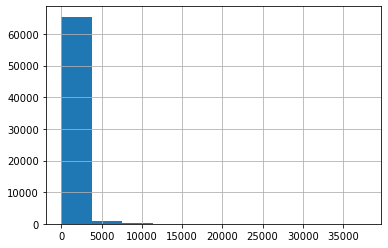

<IPython.core.display.Javascript object>

In [18]:
df.loc[:, 'peak_length'] = df.loc[:, 'peak_end'] - df.loc[:, 'peak_start']

Text(0.5, 0, 'GappedPeaks length [bp]')

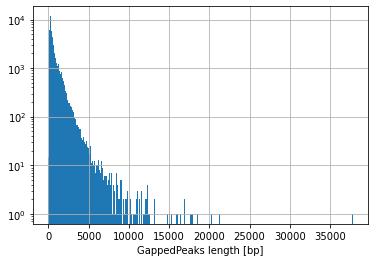

<IPython.core.display.Javascript object>

In [37]:
ax = df.peak_length.hist(bins=500)
ax.set_yscale('log')
ax.set_xlabel('GappedPeaks length [bp]')

In [22]:
df.peak_length.describe()

count    66554.000000
mean       833.231361
std        997.079576
min          0.000000
25%        300.000000
50%        490.000000
75%       1020.000000
max      37790.000000
Name: peak_length, dtype: float64

<IPython.core.display.Javascript object>

In [36]:
open_atac = df.query('peak_length <= 200 & chr == "chr15"')
open_atac = open_atac.drop(['start_locus', 'end_locus', 'peak_name', 'x', 'xx', 'rgb', 'blocks_num', 'block_length', 'block_start', 'log10p', 'log10q', 'peak_length'], axis=1).rename({'fold_change': 'intensity', 'peak_start': 'start_locus', 'peak_end': 'end_locus'}, axis=1)
open_atac.to_csv('/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/hmm_output/top_NA_peaks.bedgraph', header=None, index=False, sep='\t')

<IPython.core.display.Javascript object>

In [23]:
macs2 = pd.read_csv('/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/macs2_output/test_after_peakcalling_peaks.narrowPeak', header=None, index_col=False, names=['chr', 'start_locus', 'end_locus', 'peak_name', 'score', 'xx', 'fold_change', 'log10p', 'log10q', 'summit_pos'], sep='\t')
macs2.head()

,chr,start_locus,end_locus,peak_name,score,xx,fold_change,log10p,log10q,summit_pos
0,chr1,629098,630025,test_after_peakcalling_peak_1,538,.,4.01459,57.9828,53.8839,842
1,chr1,630244,630479,test_after_peakcalling_peak_2,383,.,3.44972,41.6757,38.3112,165
2,chr1,630788,631376,test_after_peakcalling_peak_3,498,.,3.87337,53.7366,49.8521,497
3,chr1,631889,632314,test_after_peakcalling_peak_4,487,.,3.83221,52.5300,48.7031,322
4,chr1,632508,632795,test_after_peakcalling_peak_5,470,.,3.77170,50.7577,47.0128,80


<IPython.core.display.Javascript object>

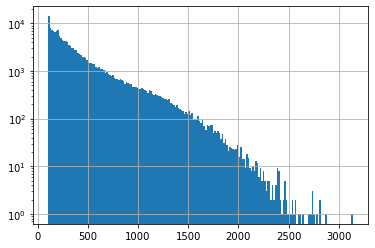

<IPython.core.display.Javascript object>

In [27]:
macs2.loc[:, "peak_size"] = macs2.loc[:, "end_locus"] - macs2.loc[:, "start_locus"]
macs2ax  = macs2.peak_size.hist(bins=200)
macs2ax.set_yscale('log')

### Normalization of Naked and Chromatin by ATAC peaks

We'll try a new method for normalization. Consider that the open parts of the genome, as detected by HMMRATAC, should have bright fluorescence, and that brightness value should be approximately equal for all open parts of the genome. Here's we'll try to find a normalization factor that turns all of the peaks of the Naked and Chromatin tracks to an equal hight, and then we could subtract the two tracks, after a normalization step or two.

This will result in a third track that should be a mirror image of the original ATAC track, since the open areas will be very low (high Naked - high chromatin) while the closed areas should be quite bright (high naked - low chromatin).

In [6]:
peak_calling_atac = pd.read_csv(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/hmm_output/NA_summits.bed",
    sep="\t",
    names=["chr", "start", "end", "peaknum", "height"],
)

This notebook currently only deals with chromosome 15, so first we filter the relevant peaks (a value of `50` was chosen, it's considered pretty standard) and then connect them to our existing 1 kb sampled index:

In [7]:
peaks_chr15 = peak_calling_atac.query('chr == "chr15" & height > 50')
peaks_chr15 = get_index_value_for_peaks(peaks_chr15, eco.data)
non_peaks_chr15 = np.setdiff1d(np.arange(len(eco.data)), peaks_chr15)

Let's first observe how does the Naked and Chromatin peak data looks like - i.e. the values of one of these tracks at the HMMRATAC-defined indices.

<AxesSubplot:xlabel='Chromatin', ylabel='Naked'>

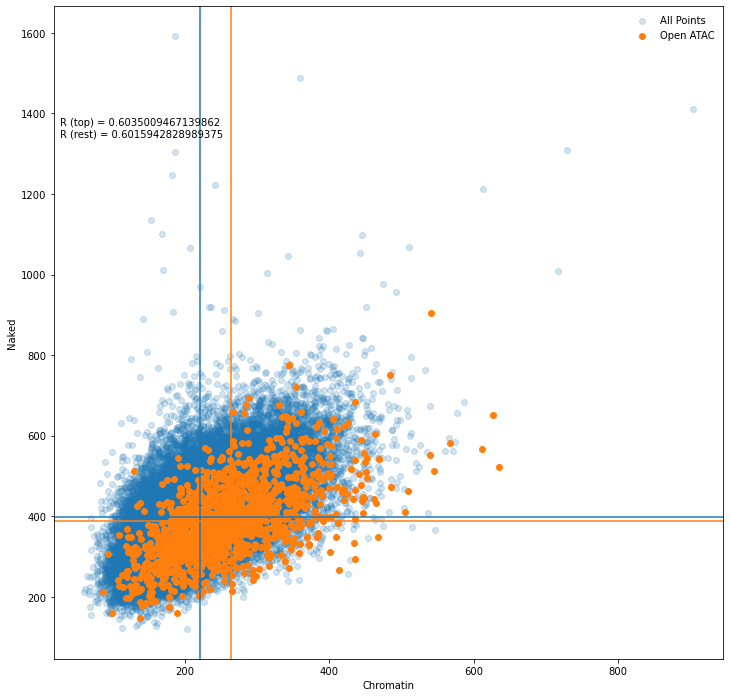

In [8]:
top_chrom, top_naked, non_top_chrom, non_top_naked = separate_top_intensity_values(eco.data, naked.data, peaks_chr15, non_peaks_chr15)
scatter_peaks_no_peaks(top_chrom, top_naked, non_top_chrom, non_top_naked)

The differences are very small - the peak-based Chromatin data is just slightly higher than the rest of the data. This is, again, a testament to the low SNR we're working with.

Befor moving on, let's look at the data in one more way:


In [9]:
all_chrom = pd.concat([non_top_chrom, top_chrom], keys=['all', 'top'])
all_naked = pd.concat([non_top_naked, top_naked], keys=['all', 'top'])
chrom_and_naked = pd.concat([all_chrom, all_naked], keys=['chrom', 'naked'])
chrom_and_naked.index.rename(['source', 'measurement', 'locus'], inplace=True)

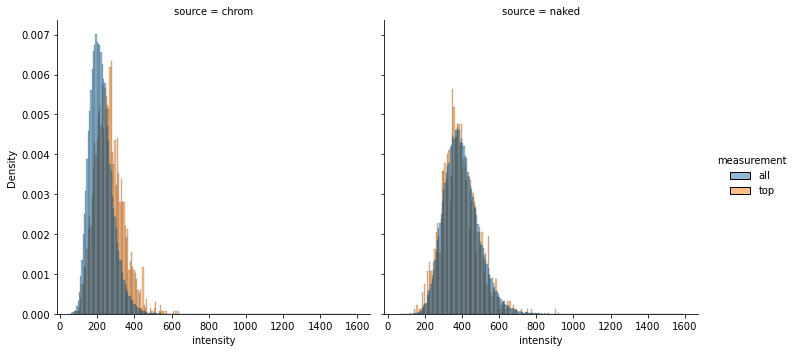

In [10]:
sns.displot(data=chrom_and_naked.to_frame(), x='intensity', hue='measurement', common_norm=False, stat='density', col='source')

We'll divide the whole chromosome into groups - each time we'll only take 100 (or so) peaks, bundle them together and do the normalization and analysis steps inside that group.

In [11]:
# Divide the peaks into groups
groupnum = 20  # nearly even groups
segments = np.linspace(0, len(peaks_chr15), num=groupnum, dtype=np.int64, endpoint=True)[1:-1]
# Define the limits of each group using peak index
peak_segments = peaks_chr15[segments]
peak_groups = np.split(peaks_chr15, segments)
# Split up data at these intervals
naked_groups = np.split(naked.data.loc[:, "intensity"], peak_segments)
chrom_groups = np.split(eco.data.loc[:, "intensity"], peak_segments)
theo_groups = np.split(theo.data.loc[:, "intensity"], peak_segments)
print(f"Generated {len(segments)} groups!")
# Change peak indices to relative per group
peak_segments = np.concatenate([[0], peak_segments])
peak_groups_relative = [
    group - starting for group, starting in zip(peak_groups, peak_segments)
]
peak_segments = np.concatenate([peak_segments, [len(naked.data)]])

Generated 18 groups!


We'll also divide the non-peak indices into the same groups - they just need a different treatment:

In [12]:
non_peak_groups = []
non_peak_groups_relative = []
for idx, start in enumerate(peak_segments[:-1]):
    end = peak_segments[idx + 1]
    mask = (non_peaks_chr15 >= start) & (non_peaks_chr15 < end)
    non_peak_groups.append(non_peaks_chr15[mask])
    non_peak_groups_relative.append(non_peaks_chr15[mask] - start)

For each of these groups we wish to draw the same scatterplot as we did before for the entire chromosome, since it might be of interest to find areas that are more or less affected by the peaks.

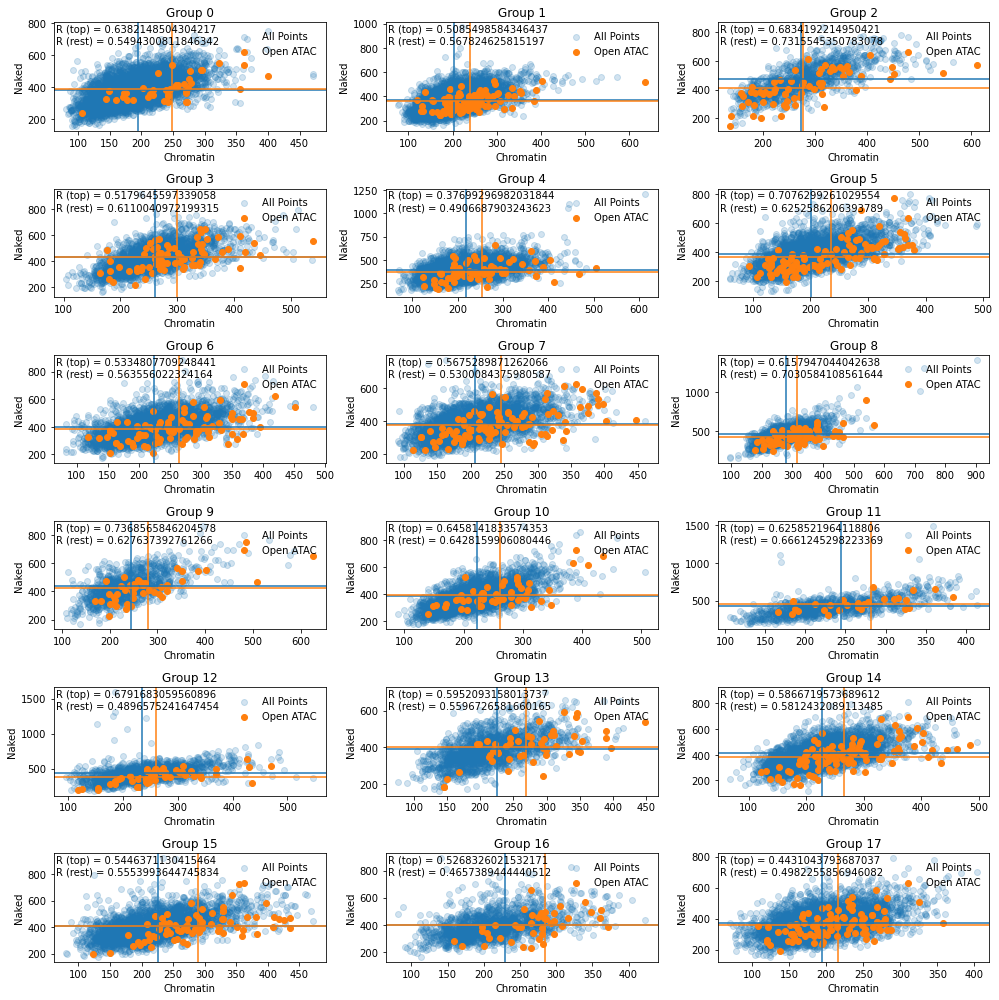

In [13]:
fig_groups, ax_groups = plt.subplots(6, 3, figsize=(14, 14))
for idx, (ax_grp, peaks, non_peaks, chrom, nak) in enumerate(zip(ax_groups.flat, peak_groups_relative, non_peak_groups_relative, chrom_groups, naked_groups)):
    ax = scatter_peaks_no_peaks(chrom.iloc[peaks], nak.iloc[peaks], chrom.iloc[non_peaks], nak.iloc[non_peaks], ax_grp)
    ax.set_title(f"Group {idx}")
ax.figure.tight_layout()
    

The main takeaways are that the chromatin data seems to be more sensitive to the peaks than the naked data. This is expected since the naked data is always open. We also see that some groups have relatively lower Chromatin SNR than other, or in other words the data in these groups doesn't reflect well the openness of the chromosome as the ATAC data suggests.

Now let's go over group-by-group and normalize the peaks between the chromatin and naked data. This normalization step is composed of two steps:

1. Match the peak heights of the naked and chromatin data. This step makes sure that the group's peaks are more-or-less identical in their average height. This is important if we wish to subtract the two tracks.
2. Remove the background noise from the tracks. The background levels of the two tracks a bit different, which might hurt the subtraction step.

After normalization we'll take two actions:

1. Generate a subtraction group after these previously-described steps.
2. Normlize the chromatin data from the naked, by equalizing the naked data's height and then applying that same filter to the chromatin data.

Regardless of the action used, we'll remove areas with low theoretical values since they're less credible. 

In [56]:
chrom_norm_groups, naked_norm_groups, chrom_normed_by_naked_groups = [], [], []
subtraction = pd.DataFrame(columns=['intensity'], index=eco.data.index)
for peaks, nakedgroup, chromgroup, theogroup in zip(peak_groups_relative, naked_groups, chrom_groups, theo_groups):
    naked_norm, norm = normalize_group_peaks_single_factor(peaks, nakedgroup)
    chrom_norm, _ = normalize_group_peaks_single_factor(peaks, chromgroup, norm_to=norm)
    naked_norm = subtract_background_with_theo(naked_norm, theogroup)
    chrom_norm = subtract_background_with_theo(chrom_norm, theogroup)
    subtraction.loc[chrom_norm.index, 'intensity'] = (naked_norm - chrom_norm)
    chrom_norm_groups.append(chrom_norm.dropna())
    naked_norm_groups.append(naked_norm.dropna())
subtraction = subtraction.dropna()
chrom_norm_all = pd.concat(chrom_norm_groups)
naked_norm_all = pd.concat(naked_norm_groups)

In [57]:
new_foldername = eco_fname.parent / 'data_after_group_norm'
new_foldername.mkdir(exist_ok=True)
write_intindex_to_disk(chrom_norm_all, new_foldername / "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_after_group_normalization.bedgraph")
write_intindex_to_disk(naked_norm_all, new_foldername / "NakedAF647_channel2_chr15_NoMissingChromatinWin_after_group_normalization.bedgraph")
write_intindex_to_disk(subtraction, new_foldername / "naked_minus_chromatin.bedgraph")

We'll plot the correlation between the theoretical data and the other datasets we currently have - subtracted track and the chromatin and naked tracks. Then we'll correct for the theoretical data and see how it looks like again.

In [58]:
theo_no_zero = theo.data.dropna()
theo_no_zero = theo_no_zero.loc[theo_no_zero.intensity != 0, "intensity"].to_frame()
theo_no_zero = theo_no_zero.reindex(subtraction.index)
theo_no_zero.loc[:, "subtraction"] = subtraction.intensity
theo_no_zero.loc[:, "chromatin"] = chrom_norm_all
theo_no_zero.loc[:, "naked"] = naked_norm_all
theo_no_zero = theo_no_zero.rename({"intensity": "theo_value"}, axis=1)

<AxesSubplot:xlabel='theo_value', ylabel='intensity'>

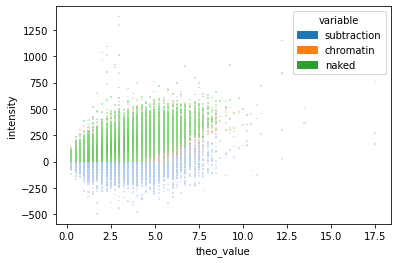

In [59]:
sns.histplot(
    data=theo_no_zero.melt(
        id_vars=['theo_value'], 
        value_name='intensity',
    ).astype({'intensity': np.float64}),  
    x='theo_value', 
    y='intensity', 
    hue='variable',
    alpha=0.5,
    linewidth=10,
)

In [60]:
subtraction.loc[:, "intensity"] = normalize_with_theo(subtraction.intensity, theo.data)
chrom_norm_theo = normalize_with_theo(chrom_norm_all, theo.data)
naked_norm_theo = normalize_with_theo(naked_norm_all, theo.data)

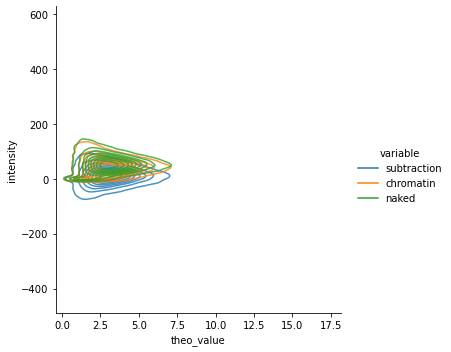

In [61]:
theo_no_zero_normed = theo_no_zero.copy()
theo_no_zero_normed.loc[:, "subtraction"] = subtraction.intensity
theo_no_zero_normed.loc[:, "chromatin"] = chrom_norm_theo
theo_no_zero_normed.loc[:, "naked"] = naked_norm_theo
sns.displot(
    data=theo_no_zero_normed.melt(
        id_vars=['theo_value'], 
        value_name='intensity',
    ).astype({'intensity': np.float64}), 
    x='theo_value', 
    y='intensity', 
    hue='variable',
    alpha=0.8,
    kind='kde',
)

In [20]:
new_foldername = eco_fname.parent / 'data_after_theo_norm'
new_foldername.mkdir(exist_ok=True)
write_intindex_to_disk(chrom_norm_all, new_foldername / "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_after_theo_normalization.bedgraph")
write_intindex_to_disk(naked_norm_all, new_foldername / "NakedAF647_channel2_chr15_NoMissingChromatinWin_after_theo_normalization.bedgraph")
write_intindex_to_disk(subtraction, new_foldername / "naked_minus_chromatin_after_theo_norm.bedgraph")

Now we'll try to look only at loci that contained a Naked-Theo wavelet correlation value higher than 0.5:

In [40]:
high_corr_fname = pathlib.Path('/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Correlations_chr15_for_histograms/Correlations_for_$4_histograms/Naked_Theoretical.0.5Up_smoothed_1kb_coerced_to_ATAC_rep1to3_Fold_change_over_control.chr15_after_normalization.bedgraph')
high_corr = BedGraph(high_corr_fname, header=False)
high_corr.data = high_corr.data.query('intensity > 0')

In [41]:
high_corrs = convert_to_intervalindex([high_corr])
high_corr = high_corrs[0]

In [52]:
merged = theo_no_zero.merge(high_corr.data, how='inner', on='locus').drop(['high_corr', 'chr', 'intensity'], axis=1)
merged = merged.melt(
        id_vars=['theo_value'], 
        value_name='intensity',
    ).astype({'intensity': np.float64})
merged

,theo_value,variable,intensity
0,2.00,subtraction,-12.848802
1,2.75,subtraction,-0.343572
2,2.25,subtraction,-18.738977
3,2.50,subtraction,-33.308902
4,4.50,subtraction,-61.203262
...,...,...,...
83557,3.00,naked,112.420073
83558,3.00,naked,122.520193
83559,1.25,naked,0.000000
83560,1.00,naked,0.000000


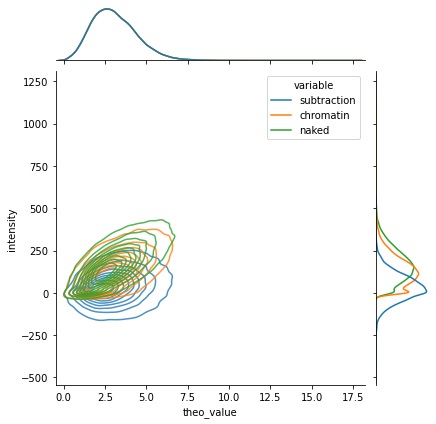

In [53]:
sns.jointplot(
    data=merged, 
    x='theo_value', 
    y='intensity', 
    hue='variable',
    alpha=0.8,
    kind='kde',
)